In [11]:
# importing the required libraries
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [12]:
# importing the training data from the training file already present in EMNIST dataset
training = torch.utils.data.DataLoader(torchvision.datasets.EMNIST(root = '/results/', split = 'letters' , train = True, download = True, transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,),(0.3081,))])),batch_size = 64, shuffle = True)
# importing the testing data
testing = torch.utils.data.DataLoader(torchvision.datasets.EMNIST(root = '/results/', split = 'letters' , train = False, download = True, transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.1307,),(0.3081,))])),batch_size = 1000, shuffle = True)



In [13]:
# creating variables to check the testing data
examples = enumerate(testing)
batch_idx, (example_data, example_targets) = next(examples)

In [14]:
example_data.shape

torch.Size([1000, 1, 28, 28])

In [15]:
example_targets.shape

torch.Size([1000])

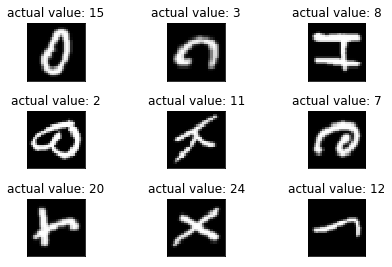

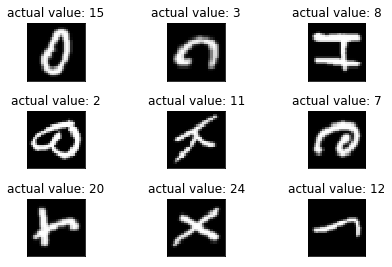

In [19]:
# creating a visual representation of the data which will be using, for better understanding
fig = plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap = 'gray', interpolation = None)
    plt.title("actual value: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig
    
    

In [104]:
# creating the neural network class. this class will consist of 1 convolutional layer, 1 max pooling layer and 3 linear layers for now. these layers will be connected by the widely used ReLU activation function. we will be using the Log softmax function for the output layer. these parameters will be varied during the subsequent runs to improve the accuracy
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
#         input is 1X28X28, output is 26 letters
        self.conv1 = nn.Conv2d(1, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(18 * 14 * 14, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 27)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 18 * 14 *14)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x)

In [123]:
# defining the relationship between input and output sizes for usage afterwards
def outputsize(in_size,kernel_size,stride,padding):
    output = int((in_size-kernel_size+2*(padding)) / stride) + 1
    return output
# defining the various hyperparameters
epochs = 3 
log_interval = 100
network = Net()
optimizer = optim.SGD(network.parameters(), lr = 0.01, momentum = 0.5)
# creating counters for our results i.e for training losses, test losses, no. of sample trained and no.of samples tested
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(training.dataset) for i in range(epochs+1)]

In [133]:
# defining the training network
def train(epoch):
    network.train()
    for batch_idx, (data,target) in enumerate(training):
#       making all the gradients zero before the start of each epoch
        optimizer.zero_grad()
#     input output and backpropagation steps along with the application of NLL loss function for now
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
#         printing the results after each mini batch has been trained during a particular epoch
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx*len(data), len(training.dataset), 100. *batch_idx / len(training), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*100) + ((epoch-1)*len(training.dataset)))
            torch.save(network.state_dict(), '/results/model.pth')
            torch.save(optimizer.state_dict(), '/results/optimizer.pth')
    

In [134]:
# defining the testing network
def test():
    network.eval()
    test_loss = 0
    correct = 0
    losstest = []
#   calculating the loss for each sample and the accuracy
    with torch.no_grad():
        for data, target in testing:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average = False).item()
            pred = output.data.max(1, keepdim = True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
#         initialising the various parameters to calculate accuracy and print it
        test_loss /= len(testing.dataset)
        losstest.append(test_loss)
        print('\nTest set: Avg. Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(testing.dataset), 100. *correct / len(testing.dataset)))
        
    

In [ ]:
# initializing the entire network with the datasets and using the above functions to calculate the accuracy
test()
for epoch in range(1,epochs+1):
    train(epoch)
    test()

C:\Users\admin\anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. Loss: 3.2989, Accuracy: 1148/20800 (5%)

Train Epoch: 1 [0/124800 (0%)]	Loss: 3.308890
Train Epoch: 1 [6400/124800 (5%)]	Loss: 2.819119
Train Epoch: 1 [12800/124800 (10%)]	Loss: 1.505797
Train Epoch: 1 [19200/124800 (15%)]	Loss: 1.153862
Train Epoch: 1 [25600/124800 (21%)]	Loss: 1.181539
Train Epoch: 1 [32000/124800 (26%)]	Loss: 0.715843
Train Epoch: 1 [38400/124800 (31%)]	Loss: 0.871129
Train Epoch: 1 [44800/124800 (36%)]	Loss: 0.896569
Train Epoch: 1 [51200/124800 (41%)]	Loss: 0.778540
Train Epoch: 1 [57600/124800 (46%)]	Loss: 0.687542
Train Epoch: 1 [64000/124800 (51%)]	Loss: 0.653501
Train Epoch: 1 [70400/124800 (56%)]	Loss: 0.622151
Train Epoch: 1 [76800/124800 (62%)]	Loss: 0.374018
Train Epoch: 1 [83200/124800 (67%)]	Loss: 0.615186
Train Epoch: 1 [89600/124800 (72%)]	Loss: 0.344304
Train Epoch: 1 [96000/124800 (77%)]	Loss: 0.406743
Train Epoch: 1 [102400/124800 (82%)]	Loss: 0.609772
Train Epoch: 1 [108800/124800 (87%)]	Loss: 0.500627
Train Epoch: 1 [115200/124800 